# Урок 4. Кейс 1. Построение и оценка модели

## Домашнее задание 4

***Вариант 1***

**1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.**

In [1]:
import numpy as np
import pandas as pd 

import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

d:\Users\Tim\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

In [3]:
df_week = data.resample('W').mean()

df_week.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000


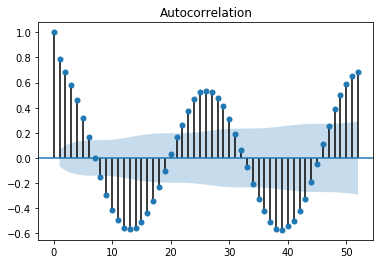

In [4]:
# отобразим автокорреляцию
sm.graphics.tsa.plot_acf(df_week['PJME_MW'].values, lags=52)
plt.show()

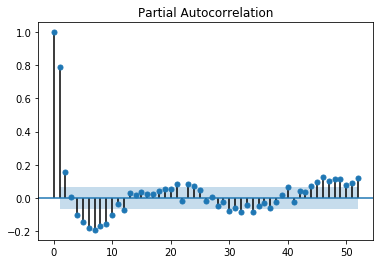

In [5]:
# отобразим частичную автокорреляцию
sm.graphics.tsa.plot_pacf(df_week['PJME_MW'].values, lags=52)
plt.show()

In [6]:
# добавим историю на глубину в 5 дней
p = 5
for i in range(p):
    df_week['t'+str(p-i)]=0
    df_week['t'+str(p-i)].values[p:] = df_week['PJME_MW'].values[i:-(p)+i]

Добавим новых признаков, описывающих содержание ряда. К таким признакам можно отнести разности ряда и разнообразные варианты сглаживания. Добавим к нашей модели 1-е разности. При этом следует помнить, что такие операции уменьшают общую длину корректной выборки на 1, т.е. первую строку данных следует исключить из модели в момент обучения.

In [7]:
first_diff =np.array(df_week.iloc[1:,0].values - df_week.iloc[:-1,0].values).astype('float32') 
df_week['diff1'] = 0
df_week['diff1'] =  df_week['diff1'].astype('float') 
df_week['diff1'].values[1:] = first_diff

In [8]:
# добавим разности на глубину 5
p = 5
for i in range(p):
    df_week['d'+str(p-i)]=0
    df_week['d'+str(p-i)].values[p:] = df_week['diff1'].values[i:-(p)+i]

In [9]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [10]:
df_week['exp_0_01'] = exponential_smoothing(df_week['PJME_MW'], 0.01)
df_week['exp_0_03'] = exponential_smoothing(df_week['PJME_MW'], 0.03)
df_week['exp_0_04'] = exponential_smoothing(df_week['PJME_MW'], 0.04)
df_week['exp_0_06'] = exponential_smoothing(df_week['PJME_MW'], 0.06)
df_week['exp_0_07'] = exponential_smoothing(df_week['PJME_MW'], 0.07)
df_week['exp_0_08'] = exponential_smoothing(df_week['PJME_MW'], 0.08)

In [11]:
df_week

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,...,d4,d3,d2,d1,exp_0_01,exp_0_03,exp_0_04,exp_0_06,exp_0_07,exp_0_08
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.580420,0.160839,...,0,0,0,0,32392.160839,32392.160839,32392.160839,32392.160839,32392.160839,32392.160839
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.500000,0.000000,...,0,0,0,0,32383.113100,32365.017621,32355.969882,32337.874403,32328.826664,32319.778924
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.500000,0.000000,...,0,0,0,0,32373.810778,32337.653521,32319.846325,32284.774796,32267.510464,32250.427087
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.500000,0.142857,...,0,0,0,0,32351.487968,32271.769808,32232.713662,32156.180094,32118.691815,32081.715301
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.500000,0.000000,...,0,0,0,0,32319.937969,32179.511357,32111.264639,31978.598574,31914.137554,31850.897124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-08,38459.982143,2018.0,7.000000,5.000000,3.0,186.000000,27.0,3.000000,11.500000,0.142857,...,-2330,1701,4394,1200,31149.351351,30974.370915,30993.168173,31080.212986,31145.037913,31223.895665
2018-07-15,36420.035714,2018.0,7.000000,12.000000,3.0,193.000000,28.0,3.000000,11.500000,0.000000,...,1701,4394,1200,2548,31202.058195,31137.740859,31210.242874,31400.602350,31514.287759,31639.586869
2018-07-22,35612.095238,2018.0,7.000000,19.000000,3.0,200.000000,29.0,3.000000,11.500000,0.000000,...,4394,1200,2548,-2039,31246.158565,31271.971490,31386.316969,31653.291923,31801.134283,31957.387539


In [12]:
h = 1
X = df_week.iloc[p:-h,:]
X.shape

(860, 29)

In [13]:
y = df_week['PJME_MW'].values[h+p:].reshape((df_week.shape[0]-h-p,1))
y.shape

(860, 1)

In [14]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

d:\Users\Tim\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


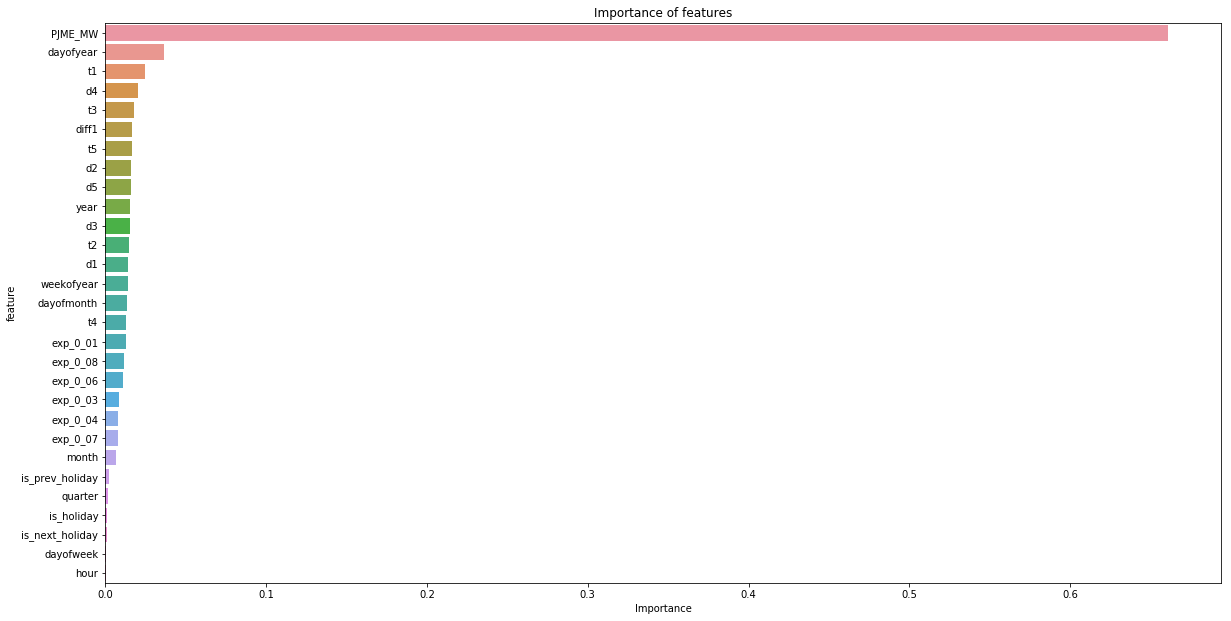

In [15]:
model_rfr = RandomForestRegressor(n_estimators=500, random_state=42, max_depth=20)
model_rfr.fit(X, y)
important_features_top = show_feature_importances(X.columns, model_rfr.feature_importances_, get_top=10)

In [16]:
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

d:\Users\Tim\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


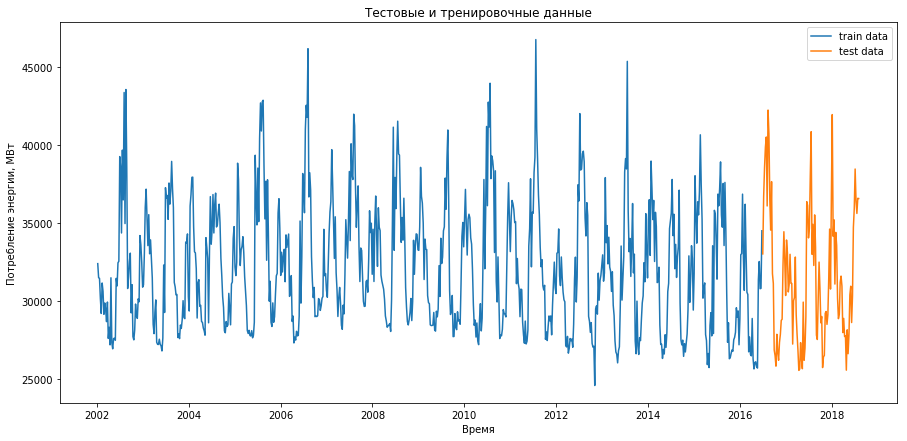

In [17]:
train, test = split_data(df_week[important_features_top], '30-06-2016')

X_train = train.iloc[:-1,:]
y_train = train['PJME_MW'].values[1:]
X_test = test.iloc[:-1,:]
y_test = test['PJME_MW'].values[1:]

X_train_4 = train.iloc[:-4,:]
y_train_4 = train['PJME_MW'].values[4:]
X_test_4 = test.iloc[:-4,:]
y_test_4 = test['PJME_MW'].values[4:]

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

**2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков.**

In [18]:
model_rfr = RandomForestRegressor(n_estimators=500, random_state=42, max_depth=20)

In [19]:
model_rfr.fit(X_train_4, y_train_4)
y_test_pred_4 = model_rfr.predict(X_test_4)

**3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.**

In [20]:
model_rfr.fit(X_train, y_train)
y_test_pred = model_rfr.predict(X_test)

**4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.**

**5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10i-й до (i+1)10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)**

In [21]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

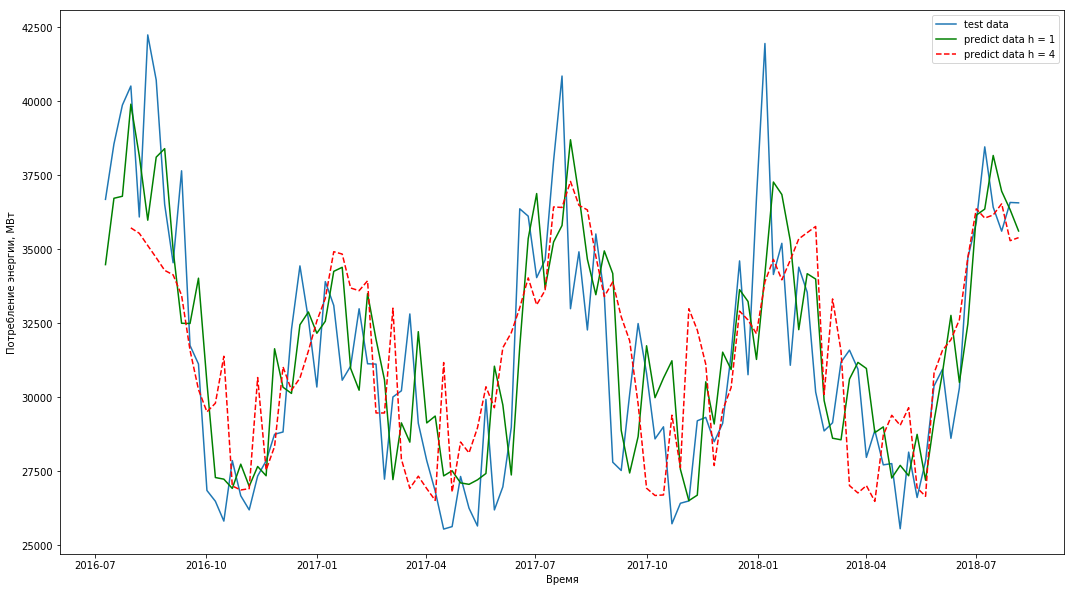

ошибка h=1:   6.501015059521882 %
ошибка h=4:   7.547274602604033 %


In [22]:
plt.figure( figsize=( 18, 10))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:],y_test, label='test data')
plt.plot(test.index[1:],y_test_pred, 'g', label='predict data h = 1')
plt.plot(test.index[4:],y_test_pred_4, '--r', label='predict data h = 4')

plt.legend()
plt.show()

er_g1 = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)
er_g4 = mean_absolute_percentage_error(y_true=y_test[3:], y_pred=y_test_pred_4)
print('ошибка h=1:  ', er_g1, '%')
print('ошибка h=4:  ', er_g4, '%')

Модель с h=1 работает лучше модели с h=4. Ошибка около 6,5%.

Построим рекурсивную модель

In [23]:
model_rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

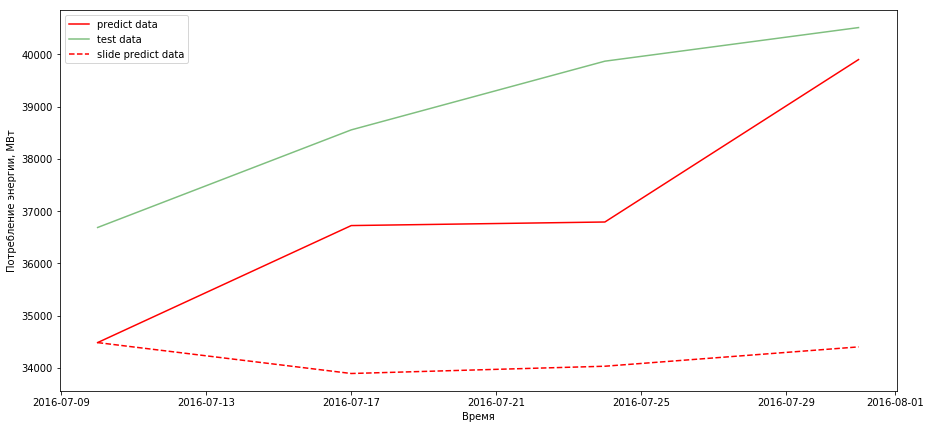

In [24]:
#['PJME_MW', 'dayofyear', 't1', 'd4', 't3', 'diff1', 't5', 'd2', 'd5', 'year']
X_test_ = X_test.values.copy()
y_test_ = y_test_pred.copy()
N4 = 4
for i in range(N4):
    y_test_[i] = model_rfr.predict(X_test_[i,:].reshape((1,10)))
    # заполняем вектор для прогноза следующей точки
    X_test_[i+1,0] = y_test_[i]
    X_test_[i+1,2] = X_test_[i,0]
    X_test_[i+1,3] = X_test_[i-3,0] - X_test_[i-4,0]
    X_test_[i+1,4] = X_test_[i-2,0]
    X_test_[i+1,5] = X_test_[i+1,0] - X_test_[i,0]
    X_test_[i+1,7] = X_test_[i,0] - X_test_[i-1,0]
    X_test_[i+1,8] = X_test_[i-3,0] - X_test_[i-4,0]
    
    X_test_[i+1,1] = X_test_[i+1,1] + 1
    if X_test_[i+1,1] > 362:
        X_test_[i+1,1] = 1
    if i > p:
         X_test_[i+1,6] = X_test_[i-4,0]
        
    
    
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N4+1],y_test_pred[:N4], 'r',label='predict data' )
plt.plot(test.index[1:N4+1],y_test[:N4], 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:N4+1],y_test_[:N4], '--r',label='slide predict data')

plt.legend()
plt.show()

In [25]:
er_g1 = mean_absolute_percentage_error(y_true=y_test_, y_pred=y_test_pred)
er_g4 = mean_absolute_percentage_error(y_true=y_test_[3:], y_pred=y_test_pred_4)
print('ошибка h=1:  ', er_g1, '%')
print('ошибка h=4:  ', er_g4, '%')

ошибка h=1:   0.2978905792718618 %
ошибка h=4:   6.1886402286444335 %


**6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.**

**Вывод:**
    При использовании рекурсивной модели процент ошибки снизился как для h=1, так и для h=4.